# Introduction to Regularization and Overfitting

Given that the goal of a supervised learning algorithm is to approximate some function based on a set of labelled input-output pairs, the number of parameters over which the learning is defined can have a significant effect on how successful this approximation is. If a model has a lot of parameters relative to the amount of training data, then the model has a considerable amount of flexibility to accurately fit the training. If the model has few parameters relative to the amount of training, this flexibility is reduced. However, there is a tradeoff between the flexibility of a model and its ability to generalize to data outside of the training set, so increasing the number of parameters is not always a good thing. This tradeoff between 'bias' (i.e. model rigidity) and 'variance' (i.e. model flexibility) can be neatly captured by a comparison between three models of a simple, low-dimensional dataset. 

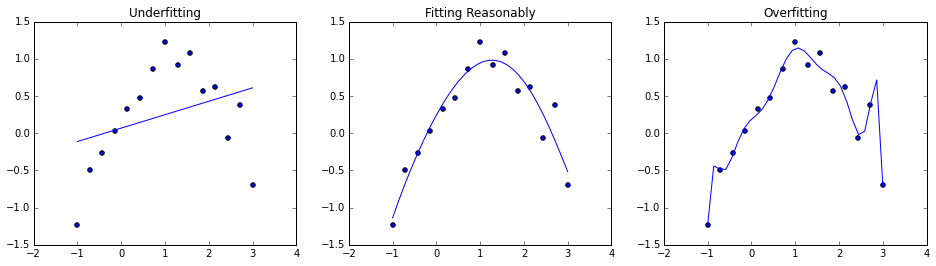

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def func(x):
    return np.sin(1.2*x) + np.random.randn(len(x)) * 0.2

# Create features and data points using random function
n=15
xs = np.linspace(-1,3,n)
ys = func(xs)
data = np.hstack((np.ones((n,1)), xs.reshape(n,1)))

# Fit with a linear model
lin_theta = np.dot(np.linalg.inv(np.dot(data.T, data)), np.dot(data.T, ys))

# Fit with a polynomial model of degree 5
low_poly = np.poly1d(np.polyfit(xs, ys, 5))

# Fit with a polynomial model of degree 10
high_poly = np.poly1d(np.polyfit(xs, ys, 10))

axis = np.linspace(-1,3,2*n)

# Plot comparisons
fig = plt.figure(figsize=(16,4))
p1 = fig.add_subplot(1,3,1)
p1.scatter(xs, ys)
p1.plot(xs, np.dot(data, lin_theta))
p1.set_title('Underfitting')
p2 = fig.add_subplot(1,3,2)
p2.scatter(xs, ys)
p2.plot(axis, low_poly(axis))
p2.set_title('Fitting Reasonably')
p3 = fig.add_subplot(1,3,3)
p3.scatter(xs, ys)
p3.plot(axis, high_poly(axis))
p3.set_title('Overfitting')
fig.show()

In the first case, the model is clearly a poor predictor of the data. It is insufficiently flexible to accomodate the non-linear relationship between the two variables of interest (i.e. $x$ and $y$). In the second case, the model does a reasonably good job, and one can imagine that the fitted polynomial would generalize well to data outside of the training set. In the third case, the model has become too flexible and has nearly fit the training data perfectly. This makes it unlikely that the model will generalize to new data well. 

The standard technique for avoiding overfitting involves adding a regularization term to the cost function that penalizes model complexity. In the case of the previously used dataset, we could perform linear regression using a large number of polynomial features (as in the third plot above), but use regularization to penalize the model for assigning large weights to the higher order polynomial features. 

# Regularization with Neural Networks

To illustrate the use of regularization in the context of training a neural network, we'll use the standard MNIST dataset of handwritten digits, along with the neural network model described in the previous notebook on backpropogation. The MNIST dataset consists of 50,000 training images and 10,000 test images, and is avaiable online in pickled format at wwww.deeplearning.net. (the dataset is several hundred megabytes, so it is not included in this repository). To illustrate the need for regularization, we'll train a network with a large number of parameters and compare the resulting error on both the training set and the testing set:

In [33]:
import cPickle
from models import NeuralNetwork 

# Load and preprocess the dataset
with open('data/mnist.pkl', 'rb') as data:
    train_set, cv_set, test_set = cPickle.load(data)

def preprocess(data):
    xs = data[0]
    xs = np.append(np.ones((len(xs),1)), xs, axis=1)    
    ys = data[1]
    return xs, ys    
    
train_data, train_targs = preprocess(train_set)
test_data, test_targs = preprocess(test_set)

# Initialize the model and display base error rates
classifier = NeuralNetwork(784, 1500, 10) 
print 'Initial Train Error: ', classifier.get_error(train_data, train_targs)
print 'Initial Test Error: ', classifier.get_error(test_data, test_targs)

Initial Train Error:  90.688
Initial Test Error:  90.77


As expected, an untrained network performs roughly at chance and misclassifies 90% of the images in both the training set and the test set. After training with stochastic gradient descent (i.e. computing the gradient of the weights using a random subset of the training data), the error rates become impressively low: 

In [34]:
classifier.train(train_data, train_targs, iters=50000)
print 'Final Train Error: ', classifier.get_error(train_data, train_targs)
print 'Final Test Error: ', classifier.get_error(test_data, test_targs)

Final Train Error:  0.544
Final Test Error:  2.2


The trained network misclassifies about the 0.5% of the training images, but about 2% of the test images. Given that this test error is about 4 times higher than the training error, it is reasonable to suppose that the network is overfitting to some extent. But to see just how well it does regardless, it helps to look at a few of the predictions made by the network on the test set:

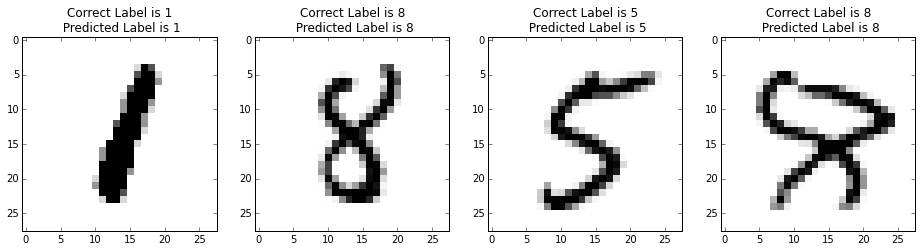

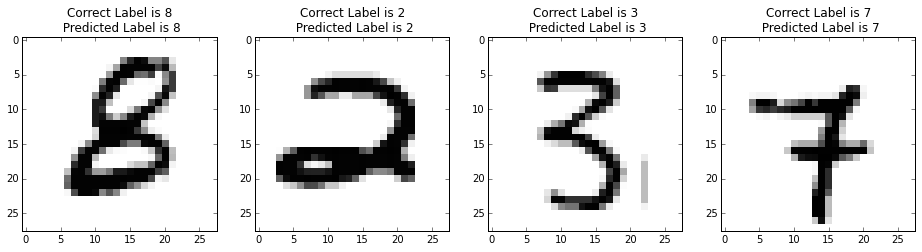

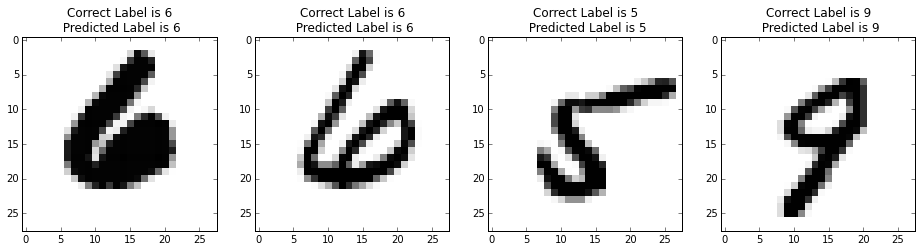

In [37]:
import matplotlib.cm as cm

predictions = classifier.predict(test_data)

# Plot some random test images with predicted classification
for i in range(3):
    indices = np.random.randint(0,10000,4)
    targs = test_targs[indices]
    preds = predictions[indices]

    fig = plt.figure(figsize=(16,8))
    p1 = fig.add_subplot(1,4,1)
    p1.imshow(test_data[indices[0],1:].reshape(28,28), cmap=cm.Greys, interpolation='Nearest')
    p1.set_title('Correct Label is %s \n Predicted Label is %s' %(targs[0], preds[0]))
    p2 = fig.add_subplot(1,4,2)
    p2.imshow(test_data[indices[1],1:].reshape(28,28), cmap=cm.Greys, interpolation='Nearest')
    p2.set_title('Correct Label is %s \n Predicted Label is %s' %(targs[1], preds[1]))
    p3 = fig.add_subplot(1,4,3)
    p3.imshow(test_data[indices[2],1:].reshape(28,28), cmap=cm.Greys, interpolation='Nearest')
    p3.set_title('Correct Label is %s \n Predicted Label is %s' %(targs[2], preds[2]))
    p4 = fig.add_subplot(1,4,4)
    p4.imshow(test_data[indices[3],1:].reshape(28,28), cmap=cm.Greys, interpolation='Nearest')
    p4.set_title('Correct Label is %s \n Predicted Label is %s' %(targs[3], preds[3]))
    fig.show()

It is also useful to plot the cost of the parameters as a function of the number of iterations. The use of stochastic gradient descent introduces a fair bit of variability into this function, but it nonetheless converges to a stable minimum. 

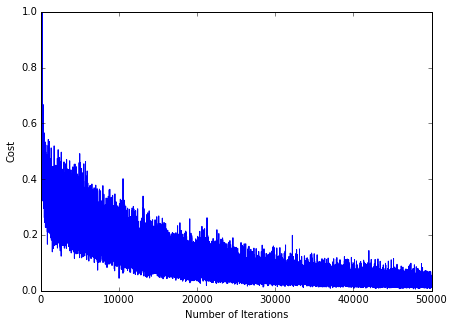

In [38]:
classifier.plot_costs()

...content in progress